## DEA comparison with Li et al.

https://genomebiology.biomedcentral.com/articles/10.1186/s13059-022-02648-4

Li et al. used 1% FDR threshold with edgeR QLF unpaired

In [1]:
import sys
import os
import logging
import glob
import pickle
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import random
from enum import Enum

logging.basicConfig(filename='example.log', 
                    encoding='utf-8', level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler(stream=sys.stdout))

#datapath = Path("../data")
datapath = "/storage/homefs/pd21v747/datanew"

modpath = Path("../scripts")
sys.path.append(os.path.relpath(modpath))

from misc import Timer, pickler, open_table
import plot_utils
npg = plot_utils.npg_palette(); jco = plot_utils.jco_palette(); colors=plot_utils.matplotlib_init()

In [28]:
from DEA import run_dea

class PermuteMode(Enum):
    
    NONE = 1
    RANDOM = 2
    BALANCED = 3
    
sites = {"thyroid": "THCA",
         "lung": "LUAD",
         "kidney": "KIRC",
         "colorectal": "COAD",
         "breast": "BRCA",
         "liver": "LIHC",
         "prostate": "PRAD",
         "synthetic": "KIRC_syn_hom"}

def subsample_df(df_full, N):
        replicates = len(df_full.columns)//2
        p = sorted(np.random.choice(range(1,replicates), N, replace=False))
        p += [pi+replicates for pi in p]    
        return df_full.iloc[:,p]   

def permute_df(df):    
    ix = list(df.columns)
    random.shuffle(ix)
    return df[pd.Index(ix)]

# quick and dirty implementation
def permute_balanced(df):
    """Make sure each permuted (fake) condition has equal number of control/treatment"""
    replicates = len(df.columns)//2
    
    if replicates % 2 != 0:
        raise Exception("Must have even number of samples")
        
    # Take first quarter of samples and swap with random treatment samples, now both conditions have equal number of control/treatment samples
    col_ix = list(range(2*replicates))
    rnd_treat_ix = np.random.choice(range(replicates, 2*replicates), replicates//2, replace=False)

    for i, j in zip(col_ix[:replicates//2], rnd_treat_ix):
        col_ix[i], col_ix[j] = col_ix[j], col_ix[i]

    cols = df.columns.values
    cols = list(cols[col_ix])
    df = df[cols]
    
    # Shuffle within each fake condition
    df_c = df.iloc[:,:replicates]
    df_c = permute_df(df_c)
    
    df_t = df.iloc[:,replicates:]
    df_t = permute_df(df_t)
    
    df = pd.concat([df_c,df_t], axis=1)
    
    if get_imbalance_ratio(df) != 0.5:
        display(df)
        raise Exception("Balancing failed")
    return df

def get_imbalance_ratio(df):
    """Return ratio of true control samples in fake control group (same as fake treatment group)"""
    replicates = len(df.columns)//2
    return sum([1 if colname.startswith("N") else 0 for colname in df.columns[:replicates]]) / replicates

def run_dea_here(df, dea):

    DEA_kwargs = {
        "edgerqlf": {"filter_expr": False, "cols_to_keep": ["logFC","logCPM","FDR"]},
        "edgerlrt": {"filter_expr": False, "cols_to_keep": ["logFC","logCPM","FDR"], "test":"lrt"},
        "deseq2": {"cols_to_keep": ["logFC","logCPM","FDR"]}
    }
   
    outfile = "/storage/homefs/pd21v747/datanew/test/dea_test.csv"

    run_dea(df, outfile, dea, overwrite=True, design="GSE91061" if GSE91061 else "unpaired", lfc=0, **DEA_kwargs[dea])
    return pd.read_csv(outfile, index_col=0)

In [3]:
site = "prostate"
data = sites[site]

permute = PermuteMode.RANDOM
subsample = True
N = 6

f = datapath + f"/{site}/{data}/{data}.csv"
#f = "/storage/homefs/pd21v747/datanew/GSE91061/GSE91061_BMS038109Sample.hg19KnownGene.raw.csv"

GSE91061 = "GSE91061" in f

df_full = pd.read_csv(f, index_col=0, header=0)

print("Running on " + ("GSE91061" if GSE91061 else "TCGA") + " data")

if(GSE91061):
    pre = list(df_full.columns)
    pre = [p for p in pre if "_Pre_" in p]
    on = df_full.columns.difference(set(pre))
    ix = pd.Index(pre+list(on))
    df_full = df_full[ix]

df_full

Running on TCGA data


,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,...,T43,T44,T45,T46,T47,T48,T49,T50,T51,T52
ENSG00000000003,3913,4568,7104,7692,3002,3313,3926,3117,6964,1467,...,6379,4384,4717,4556,4856,7170,7325,4697,4024,8809
ENSG00000000419,1164,1607,2043,1931,1329,1594,1378,1663,2853,1855,...,1762,1657,1201,2174,2083,1456,1290,1027,1617,2954
ENSG00000000457,959,1215,1643,1817,1082,1028,1147,1334,1727,886,...,1507,2060,1057,1669,2139,1292,1151,699,1084,1258
ENSG00000000460,173,194,297,304,299,207,228,278,239,199,...,306,237,262,339,256,189,345,172,292,171
ENSG00000000938,231,234,496,119,419,605,547,409,580,352,...,463,138,203,526,195,302,262,343,173,329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000281571,30,21,45,20,22,25,15,11,40,12,...,34,56,34,17,21,39,32,34,22,81
ENSG00000281649,3850,4769,6607,9611,4702,3541,5692,4845,6766,2631,...,6146,6546,5314,7317,6360,6068,7782,7557,4706,6929
ENSG00000281896,23,38,51,39,29,47,26,40,50,15,...,27,35,21,69,42,34,40,13,28,24
ENSG00000281903,6,16,20,35,25,12,22,17,19,3,...,9,21,8,14,22,12,32,35,11,12


# Balanced vs imbalanced permutations

In [4]:
overwrite = 0

FDR = 0.01
all_N = [4,8,16,32,"all"]

permute_modes = [PermuteMode.RANDOM, PermuteMode.BALANCED, PermuteMode.NONE]

if "sig_dict" not in globals():
    
    if os.path.isfile("../data/misc/permuted_degs.txt"):
    
        with open("../data/misc/permuted_degs.txt", "rb") as f:
            sig_dict = pickle.load(f)
            print("Loaded sig dict")
    
    else:
        sig_dict = {site:{p: {N:None for N in all_N} for p in permute_modes} }

if site not in sig_dict:
    sig_dict[site] = {p: {N:None for N in all_N} for p in permute_modes}

is_dirty = False

with Timer(name="context manager"):
    for N in all_N:

        df = df_full if (N == "all") else subsample_df(df_full, N)
            
        for permute_mode in permute_modes:

            if not overwrite and sig_dict[site][permute_mode][N] != None:
                print("Skipped existing calculation: ", site, N, permute_mode)
                continue

            is_dirty = True

            if permute_mode == PermuteMode.BALANCED:
                
                if len(df.columns)//2 % 2 != 0:
                    drop_patient = df.columns[0]
                    df = df.drop([drop_patient, drop_patient.replace("N","T")], axis=1)
                    print("Dropping one patient, now df has", len(df.columns), "cols")
                    
                df_perm = permute_balanced(df) # re-use subsampled df, so avoid conflict with random permuted df
                
            elif permute_mode == PermuteMode.RANDOM:
                df_perm = permute_df(df)

            res = run_dea_here(df_perm, "edgerqlf")

            sig = res[res["FDR"]<FDR]
            sig_dict[site][permute_mode][N] = len(sig)
            print(N, sig_dict[site][permute_mode][N])
        
if is_dirty:
    pickler(sig_dict, "../data/misc/permuted_degs.txt")
    print("Saving sig dict")

Loaded sig dict
Skipped existing calculation:  prostate 4 PermuteMode.RANDOM
Skipped existing calculation:  prostate 4 PermuteMode.BALANCED
Skipped existing calculation:  prostate 4 PermuteMode.NONE
Skipped existing calculation:  prostate 8 PermuteMode.RANDOM
Skipped existing calculation:  prostate 8 PermuteMode.BALANCED
Skipped existing calculation:  prostate 8 PermuteMode.NONE
Skipped existing calculation:  prostate 16 PermuteMode.RANDOM
Skipped existing calculation:  prostate 16 PermuteMode.BALANCED
Skipped existing calculation:  prostate 16 PermuteMode.NONE
Skipped existing calculation:  prostate 32 PermuteMode.RANDOM
Skipped existing calculation:  prostate 32 PermuteMode.BALANCED
Skipped existing calculation:  prostate 32 PermuteMode.NONE
Skipped existing calculation:  prostate all PermuteMode.RANDOM
Skipped existing calculation:  prostate all PermuteMode.BALANCED
Skipped existing calculation:  prostate all PermuteMode.NONE
Elapsed time: 0.0044 seconds


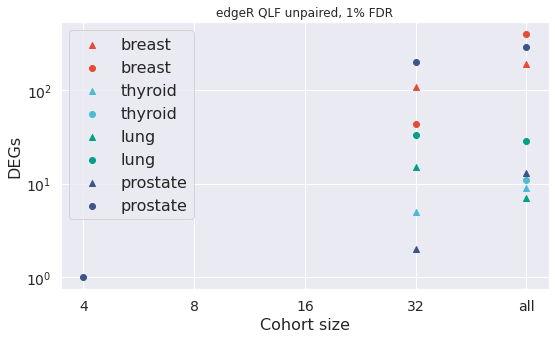

In [5]:
if "sig_dict" not in globals():
    with open("/../data/misc/permuted_degs.txt", "rb") as f:
        sig_dict = pickle.load(f)
        print("Loaded sig dict")


fig, ax = plt.subplots(1,1,figsize=(8,5))


for i, site in enumerate(sig_dict):
    
    color = npg[i]
    
    for j, permute_mode in enumerate(permute_modes):
        
        if permute_mode == PermuteMode.NONE:
            continue
            
        marker = "o" if permute_mode == PermuteMode.BALANCED else "^"
    
        for k, N in enumerate(all_N):

            ax.scatter(k,sig_dict[site][permute_mode][N],color=color,label=site if k == 0 else None, marker=marker)
        
ax.set(xlabel="Cohort size", ylabel="DEGs", title="edgeR QLF unpaired, 1% FDR")
ax.set_xticks(range(len(all_N)))
ax.set_xticklabels(all_N)
ax.legend()
ax.set_yscale("log")

figpath = f"../figures/permuted_degs.pdf"
fig.tight_layout()
fig.savefig(figpath)

# DEGs vs imbalance ratio

In [18]:
new_row = {'N':N, 'Site':site, 'Trial':trial, 'Val': (imbalance_ratio, len(sig))}
combined

Empty DataFrame
Columns: [(prostate, 32, 0, Balance Ratio), (prostate, 32, 0, DEGs)]
Index: []

In [20]:
combined_old = pd.read_csv("../data/misc/imba_old.csv")

combined_old

,Unnamed: 0,Site,N,Trial,Balance Ratio,DEGs,IsBalanced
0,0,breast,32,0,0.53125,1,0.0
1,1,breast,32,1,0.46875,3,0.0
2,2,breast,32,2,0.59375,3,0.0
3,3,breast,32,3,0.62500,3,0.0
4,4,breast,32,4,0.43750,1,0.0
...,...,...,...,...,...,...,...
115,115,synthetic,32,10,0.56250,15,NaN
116,116,synthetic,32,11,0.53125,1,NaN
117,117,synthetic,32,12,0.59375,1,NaN
118,118,synthetic,32,13,0.46875,1,NaN


In [ ]:
overwrite = 0

FDR = 0.01
all_N = [8]
trials = 2

if "combined" not in globals():
    
    if os.path.isfile("../data/misc/imba.csv"):
        combined = pd.read_csv("../data/misc/imba.csv")
        print("Loaded existing table")

    else:
        combined = pd.DataFrame(columns=["Site","N","Trial","Balance Ratio","DEGs"])
        print("Created new table")
    
is_dirty = False

with Timer(name="context manager"):
    for site in sites:
        
        data = sites[site]
        f = datapath + f"/{site}/{data}/{data}.csv"
        df_full = pd.read_csv(f, index_col=0, header=0)
            
        for N in all_N:

            df = df_full if (N == "all") else subsample_df(df_full, N)
            
            for trial in range(trials):

                row = combined.query(f"N=={N} and Site == '{site}' and Trial == {trial}")

                if not overwrite and len(row) > 0:
                    print("Skipped existing calculation: ", site, N, trial)
                    continue

                is_dirty = True

                df_perm = permute_df(df)
                res = run_dea_here(df_perm, "edgerqlf")

                sig = res[res["FDR"]<FDR]

                imbalance_ratio=get_imbalance_ratio(df_perm)
                
                if len(row) < 1:
                    print(N,site,trial,len(sig),imbalance_ratio)
                    new_row = {'N':N, 'Site':site, 'Trial':trial, 'Balance Ratio': imbalance_ratio, "DEGs": len(sig)}
                    combined = combined.append(new_row, ignore_index=True)
                else:
                    combined.loc[row.index, "DEGs"] = len(sig)
                    combined.loc[row.index, "Balance Ratio"]  = imbalance_ratio

                display(combined.iloc[-1])
        
if is_dirty:
    combined.to_csv("../data/misc/imba.csv")
    print("Saving table")

Loaded table
Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


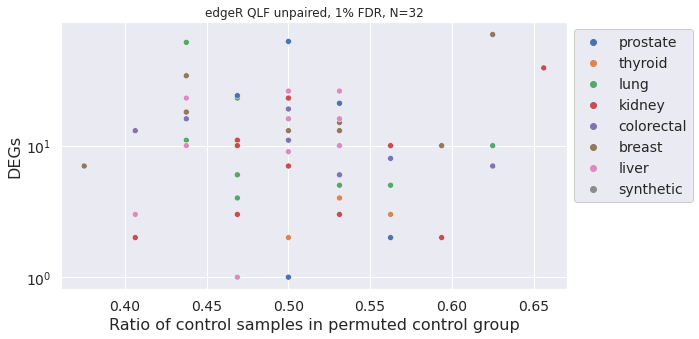

In [4]:
if "combined" not in globals():
    combined = pd.read_csv("../data/misc/imba.csv")
    print("Loaded table")
    

fig, ax = plt.subplots(1,1,figsize=(10,5))

N = 32

combined_N = combined[combined["N"]==N]

sns.scatterplot(data=combined_N, x="Balance Ratio", y="DEGs", hue="Site", ax=ax)

ax.set(xlabel="Ratio of control samples in permuted control group", ylabel="DEGs", title=f"edgeR QLF unpaired, 1% FDR, N={N}")
ax.legend(bbox_to_anchor=(1, 1), fancybox=True, shadow=False, ncol=1,fontsize=14,framealpha=1)
ax.set_yscale("log")

figpath = f"../figures/degs_vs_imbalance_ratio.pdf"
fig.tight_layout()
fig.savefig(figpath)

In [5]:
combined["IsBalanced"] = combined["Balance Ratio"] == 0.5

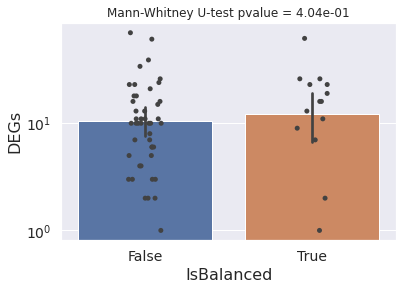

In [37]:
from scipy.stats import mannwhitneyu

balanced_degs = combined[combined["IsBalanced"]]["DEGs"]
imbalanced_degs = combined[~combined["IsBalanced"]]["DEGs"]
U1, p = mannwhitneyu(balanced_degs, imbalanced_degs)

sns.barplot(data=combined, x= "IsBalanced", y = "DEGs")
sns.stripplot(data=combined, x= "IsBalanced", y = "DEGs", color="#424242")
plt.yscale("log")
plt.title(f"Mann-Whitney U-test pvalue = {p:.2e}")
fig.tight_layout()
fig.savefig(figpath)
figpath = f"../figures/balanced_vs_imbalanced_degs.pdf"

<AxesSubplot:xlabel='IsBalanced', ylabel='DEGs'>

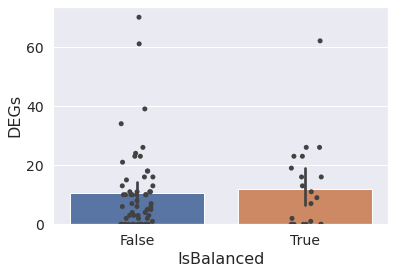

In [38]:
sns.barplot(data=combined, x= "IsBalanced", y = "DEGs")
sns.stripplot(data=combined, x= "IsBalanced", y = "DEGs", color="#424242")

# Wilcoxon

In [39]:
import scipy
scipy.__version__

'1.6.3'

In [47]:
site = "breast"
data = sites[site]
f = datapath + f"/{site}/{data}/{data}.csv"
df_full = pd.read_csv(f, index_col=0, header=0)
df = df_full#.iloc[:100]

In [ ]:
from DEA import normalize_counts

df = permute_df(df)
df_norm = normalize_counts(df)

In [ ]:
df_N = df_norm.iloc[:,:len(df_norm.columns)//2]
df_T = df_norm.iloc[:,len(df_norm.columns)//2:]

In [ ]:
from scipy.stats import ranksums


pvals = []
for i in range(len(df_N)):
    if i % 1000 == 0: 
        print(i)
    res = ranksums(df_N.iloc[i], df_T.iloc[i])
    pvals.append(res[1])

In [ ]:
from statsmodels.stats.multitest import multipletests
fdr = multipletests(pvals, method="fdr_bh")[1]

In [ ]:
fdr[fdr<0.05]

In [ ]:
plt.hist(fdr)

In [81]:
# class ImbalanceContainer:

#     def __init__(self, degs, imbalance_ratio):

#         self.degs = degs
#         self.imbalance_ratio = imbalance_ratio
        
#     def __repr__(self):
#         return f"DEGs: {self.degs} | Imbalance ratio: {self.imbalance_ratio}"
    
# pickle problematic with custom classes

# site = "kidney"

# overwrite = 0

# FDR = 0.01
# all_N = [32]
# trials = 10


# if "imba_dict" not in globals():
    
#     if os.path.isfile("../data/misc/imba_dict.txt"):
    
#         with open("../data/misc/imba_dict.txt", "rb") as f:
#             imba_dict = pickle.load(f)
#             print("Loaded sig dict")

#     else:
#         imba_dict = {site: {N: {t: None for t in range(trials)} for N in all_N } }

# if site not in imba_dict:
#     imba_dict[site] = {N: {t: None for t in range(trials)} for N in all_N }
    
# for site in imba_dict.keys():
#     for N in all_N:
#         if N not in imba_dict[site]:
#             imba_dict[site][N] = {t: None for t in range(trials)}
            
#         for trial in range(trials):
                
#             if trial not in imba_dict[site][N]:
#                 imba_dict[site][N] = {trial: None}

# is_dirty = False

# with Timer(name="context manager"):
#     for N in all_N:

#         df = df_full if (N == "all") else subsample_df(df_full, N)
            
#         for trial in range(trials):

#             if not overwrite and imba_dict[site][N][trial] != None:
#                 print("Skipped existing calculation: ", site, N, trial)
#                 continue

#             is_dirty = True

#             df_perm = permute_df(df)
#             res = run_dea_here(df_perm, "edgerqlf")

#             sig = res[res["FDR"]<FDR]
#             imba_dict[site][N][trial] = ImbalanceContainer(degs=len(sig),imbalance_ratio=get_imbalance_ratio(df_perm))
#             print(N, trial, imba_dict[site][N][trial])
        
# if is_dirty:
#     pickler(imba_dict, "../data/misc/imba_dict.txt")
#     print("Saving imba dict")

# def tidy_df(imba_dict, sites, all_N, trials):
#     if type(trials) != range:
#         trials = range(trials)
#     quantity = ["Balance Ratio", "DEGs"]
#     sites = [site for site in sites if site in imba_dict.keys()]
#     iterables = [sites, all_N, trials, quantity]
#     multi_cols = pd.MultiIndex.from_product(iterables, names=["Site", "N", "Trial", "Val"])
#     combined = pd.DataFrame(columns=multi_cols)
    
#     for site in sites:
#         for N in all_N:
#             for trial in trials:
#                 for quant in quantity:
#                     col = (site, N, trial, quant)
#                     if (quant == "Balance Ratio"):
#                         combined.loc[0, col] = imba_dict[site][N][trial].imbalance_ratio
#                     else:
#                         combined.loc[0, col] = imba_dict[site][N][trial].degs
    
#     # Conver to long form
#     combined = combined.unstack().unstack(level="Val").reset_index(level=["Site","N","Trial"], drop=False)
#     combined.reset_index(drop=True, inplace=True)
#     return combined

# combined = tidy_df(imba_dict, sites, all_N, trials)